In [735]:
! pip install scikit-optimize


     |████████████████████████████████| 100 kB 3.4 MB/s ta 0:00:011


In [ ]:
! pip install missingpy
!pip install sklearn
!pip install -U pydotplus
! pip install graphviz
! pip install catboost
! pip install fitter
! pip install scikit_posthocs

In [2]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats
import statsmodels.api as sm
import sys
import re
import scikit_posthocs as sp

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.model_selection import ShuffleSplit
import graphviz



In [3]:
df = pd.read_csv("Cazoo_new.csv")

In [4]:
df.head()

,Brand,Make,Year,Mileage,Engine_Size,Transmission,Seats,Body_Type,Colour,Drive_Type,...,Emissions,ULEZ_Exempt,Top_speed,Accelaration_0_62,Power,Tax,Insurance,Mpg,Service_record,Price
0,Kia,Picanto,2015,54990,1.0,Manual,5,3 door Hatchback,White,Front wheel drive,...,105g/km (band B),1,98.0,14.4,66.0,£20 / year,2,62.8,6,5700
1,Dacia,Sandero,2016,24138,0.9,Manual,5,5 door Hatchback,Chestnut,Front wheel drive,...,109g/km (band B),1,109.0,11.1,89.0,Not available,8,57.7,0,6250
2,Ford,Ka,2015,30571,1.2,Manual,4,3 door Hatchback,Black,Front wheel drive,...,115g/km (band C),1,99.0,13.4,68.0,Not available,3,57.7,3,6300
3,Fiat,Punto,2016,38799,1.2,Manual,5,5 door Hatchback,Ambient White,Front wheel drive,...,124g/km (band D),1,97.0,14.4,69.0,Not available,8,53.3,5,6400
4,Volkswagen,up!,2016,58887,1.0,Manual,4,3 door Hatchback,Yellow,Front wheel drive,...,105g/km (band B),1,99.0,14.4,59.0,Not available,2,62.8,7,6450


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7509 entries, 0 to 7508
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Brand              7509 non-null   object 
 1   Make               7509 non-null   object 
 2   Year               7509 non-null   int64  
 3   Mileage            7509 non-null   int64  
 4   Engine_Size        7381 non-null   float64
 5   Transmission       7509 non-null   object 
 6   Seats              7509 non-null   int64  
 7   Body_Type          7509 non-null   object 
 8   Colour             7509 non-null   object 
 9   Drive_Type         7508 non-null   object 
 10  Registration       7509 non-null   object 
 11  Previous_Owners    7509 non-null   int64  
 12  Keys               7509 non-null   int64  
 13  Emissions          7509 non-null   object 
 14  ULEZ_Exempt        7509 non-null   int64  
 15  Top_speed          7501 non-null   float64
 16  Accelaration_0_62  7244 

In [7]:
df['Tax'].value_counts().head() #Not available ie missing values make a major proportion of data in this column therefore its better to delete this column.

Not available    3708
£165 / year      2550
£0 / year         341
£520 / year       216
£155 / year       171
Name: Tax, dtype: int64

In [8]:
df.drop(columns = "Tax", inplace = True)

In [9]:
df['Emissions'].unique()

array(['105g/km (band B)', '109g/km (band B)', '115g/km (band C)',
       '124g/km (band D)', '128g/km (band D)', '110g/km (band B)',
       '109g/km (band F)', '104g/km (band B)', '168g/km (band H)',
       '117g/km (band G)', '95g/km (band A)', '108g/km (band B)',
       '122g/km (band D)', '107g/km (band B)', '130g/km (band D)',
       '99g/km (band A)', '95g/km (band E)', '118g/km (band C)',
       '102g/km (band F)', '106g/km (band F)', '120g/km (band C)',
       '100g/km (band A)', '89g/km (band D)', '140g/km (band E)',
       '87g/km (band A)', '120g/km (band G)', '140g/km (band H)',
       '106g/km (band B)', '88g/km (band A)', '119g/km (band G)',
       '108g/km (band F)', '110g/km (band F)', '114g/km (band G)',
       '93g/km (band E)', '101g/km (band B)', '114g/km (band C)',
       '124g/km (band G)', '152g/km (band G)', '139g/km (band H)',
       '99g/km (band E)', '85g/km (band A)', '103g/km (band B)',
       '101g/km (band F)', '127g/km (band D)', '113g/km (band G)',
    

The emissions feature can be used as both a continous and categorical feature, since each emmision value corrosponds to a categorical level.

In [10]:
df['Emissions'].isnull().sum()

0

In [11]:
failure_index = []
failure_number = []
success = []
for i in range(0,len(df)):
    if pd.notna(df.loc[i, 'Emissions']): 
        f = re.search( '(?!band|Band\s)[A-Z]',df.loc[i, 'Emissions']) # If emission tax band is mentioned extract
        if f == None: # If no emissions band is mentioned 
            digit = re.search( '\d+\d',df.loc[i, 'Emissions']).group()# extract emission number in g/km carbon
            failure_index.append(i) # append index if emissions band is not included
            failure_number.append(int(digit))# turn the emissions value in g/km into a intega
                
        else:
            success.append(f.group())
    else:
        continue

In [12]:
failure_names = df.loc[failure_index,'Make']

In [13]:
failure_names

195                       Mokka
230                        AYGO
242                         500
395                       Mokka
412                        AYGO
                 ...           
7451                         Q7
7453                         Q5
7481                      Macan
7507    Rover Range Rover Sport
7508                  GLE Class
Name: Make, Length: 702, dtype: object

In [14]:
failure_names.unique() # If emission band is not avaialable its due to the presence of only emission value in g/km or an electric in which case its in Band A

array(['Mokka', 'AYGO', '500', '2008', 'Focus', '500X', 'C3', 'Juke',
       'Rapid Spaceback', 'Corsa', 'Swift', 'C1', '108', 'Mazda3', 'Polo',
       'Mokka X', 'Clio', 'C4 Cactus', 'Civic', 'Sandero Stepway',
       'Captur', 'forfour', 'Pulsar', '208', 'Fabia', 'Qashqai',
       '2 Series Active Tourer', 'Leon', 'Golf', 'Megane', 'Picanto',
       'Mondeo', 'A1', 'EcoSport', '308', 'Stonic', 'Sportage', 'Passat',
       'Micra', 'i40', 'Vitara', 'Rio', 'Octavia', 'Grandland X',
       'B Class', 'MG ZS', 'Grand C4 Picasso', 'Mazda2', 'CX-3',
       '124 Spider', '2 Series', 'Convertible', 'Kadjar', 'HR-V',
       'X-Trail', 'TUCSON', 'T-Roc', 'GS', 'Ceed', 'Fiesta', 'Kuga',
       'Ateca', '2 Series Gran Tourer', 'Duster', 'Yaris', 'A Class',
       '500C', 'XCeed', 'Optima', '3008', 'Crossland', 'Crossland X',
       'XE', 'Combo Life', 'A3', '595', 'Jazz', 'i10', 'V40',
       'Countryman', 'A4', '1 Series', 'Insignia', 'CR-V', 'Arona',
       'Karoq', 'Q3', 'Rover Range Rover Ev

In [15]:
band = []
for i in range(0,len(df)):
    if pd.notna(df.loc[i, 'Emissions']): 
        f = re.search( '(?!band|Band\s)[A-Z]',df.loc[i, 'Emissions']) # If emission tax band is mentioned extract
        if f == None: # If no emissions band is mentioned 
            digit_str = re.search( '\d+\d',df.loc[i, 'Emissions']).group()# extract emission number in g/km carbon
            digit = int(digit_str)
            if digit <= 100:
                df.loc[i,'Emissions'] = 'A'
            elif digit > 100 and digit <= 110:
                df.loc[i,'Emissions'] ='B'
            elif digit > 110 and digit <= 120:
                df.loc[i,'Emissions'] ='C'
            elif digit > 120 and digit <= 130:
                df.loc[i,'Emissions'] = 'D'
            elif digit > 130 and digit <= 140:
                df.loc[i,'Emissions'] = 'E'
            elif digit > 140 and digit <= 150:
                df.loc[i,'Emissions']='F'
            elif digit > 150 and digit <= 165:
                df.loc[i,'Emissions']='G'
            elif digit > 165 and digit <= 175:
                df.loc[i,'Emissions'] = 'H'
            elif digit > 175 and digit <= 185:
                df.loc[i,'Emissions'] = 'I'
            elif digit > 185 and digit <= 200:
                df.loc[i,'Emissions'] = 'J'
            elif digit > 200 and digit <= 225:
                df.loc[i,'Emissions'] = 'K'
            elif digit > 225 and digit <= 255:
                df.loc[i,'Emissions'] = 'L'
        else:
            df.loc[i,'Emissions'] = f.group()
    else:
        continue

In [16]:
object_col = df.select_dtypes(include = 'object').columns 
df[object_col] = df[object_col].astype("string") # change column type from object to string

In [17]:
X_cols = df.drop(columns = "Price")
target = "Price"

In [18]:
cat_cols = df.select_dtypes(include = 'string') # all categorical features
num_cols = X_cols.select_dtypes(exclude = 'string') # all continous features

In [19]:
num_col =num_cols.columns.to_list()
cat_cols = cat_cols.columns.to_list()

## Explorotory Data Analysis

#### Target distribution

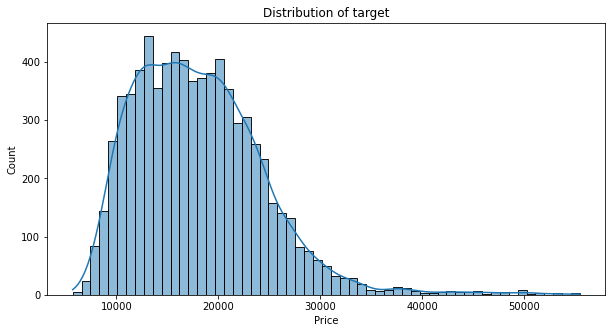

In [20]:
plt.figure(figsize = (10,5))
sns.histplot(df[target], kde = True)
plt.title("Distribution of target")
plt.show()

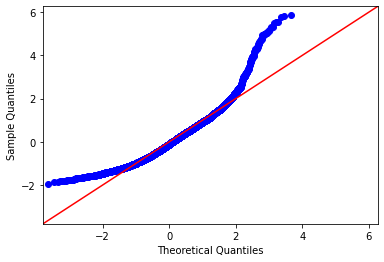

In [21]:
sm.qqplot(df[target],line='45',fit=True,dist=stats.norm)
plt.show()

The target variable is not normally distributed

### Distribution of continous variables

In [22]:
continous = list((set(num_col) -  set(['ULEZ_Exempt','Insurance','Previous_Owners','Seats', 'Keys','Service_record'])))

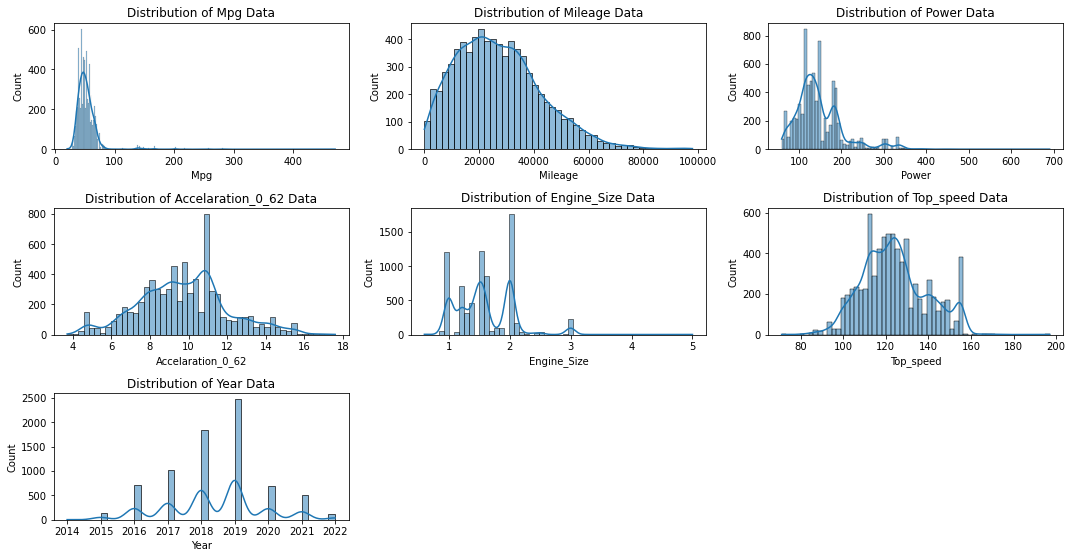

In [23]:
plt.figure(figsize = (15,10))
for i,col in enumerate(continous):
    plt.subplot(4,3,i+1)
    plt.title(f"Distribution of {col} Data")
    sns.histplot(df[col],kde = True)
    plt.tight_layout()
    plt.plot()

In [24]:
df_fill0 = df[continous].fillna(0)

In [25]:
df_fill0

,Mpg,Mileage,Power,Accelaration_0_62,Engine_Size,Top_speed,Year
0,62.8,54990,66.0,14.4,1.0,98.0,2015
1,57.7,24138,89.0,11.1,0.9,109.0,2016
2,57.7,30571,68.0,13.4,1.2,99.0,2015
3,53.3,38799,69.0,14.4,1.2,97.0,2016
4,62.8,58887,59.0,14.4,1.0,99.0,2016
...,...,...,...,...,...,...,...
7504,0.0,12494,402.0,5.7,0.0,124.0,2020
7505,31.7,28024,302.0,7.5,3.0,130.0,2019
7506,27.7,4706,242.0,6.7,2.0,139.0,2020
7507,32.1,17338,302.0,7.1,3.0,130.0,2019


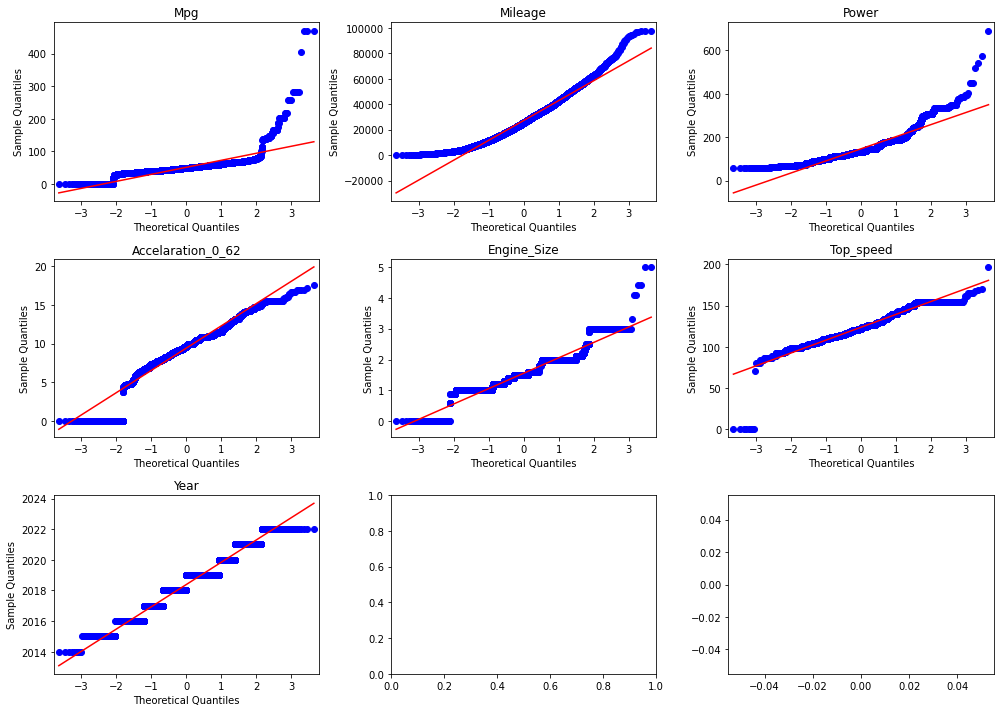

In [26]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(14, 10))
plt.subplots_adjust(hspace=0.5)

for col, ax in zip(continous, axs.ravel()):
    
    sm.qqplot(df_fill0[col], line='s', ax = ax)
    ax.set_title(col)
    plt.tight_layout()
    plt.plot()
    

In [27]:
for i in continous:
    shapiro_test = stats.kstest(df_fill0[i],"norm")
    print(f"Kolmongrov-Smirnov for variable {i}: {shapiro_test}")

Kolmongrov-Smirnov for variable Mpg: KstestResult(statistic=0.98215474763617, pvalue=0.0)
Kolmongrov-Smirnov for variable Mileage: KstestResult(statistic=1.0, pvalue=0.0)
Kolmongrov-Smirnov for variable Power: KstestResult(statistic=1.0, pvalue=0.0)
Kolmongrov-Smirnov for variable Accelaration_0_62: KstestResult(statistic=0.964601216114172, pvalue=0.0)
Kolmongrov-Smirnov for variable Engine_Size: KstestResult(statistic=0.8157754292487267, pvalue=0.0)
Kolmongrov-Smirnov for variable Top_speed: KstestResult(statistic=0.9989346117991743, pvalue=0.0)
Kolmongrov-Smirnov for variable Year: KstestResult(statistic=1.0, pvalue=0.0)


None of the continous predictor variables are normally distributed

### Distribution of categorical variables

In [28]:
cat_features = cat_cols +['ULEZ_Exempt','Insurance','Previous_Owners','Seats', 'Keys','Service_record']
cat_features.remove("Registration")

In [29]:
cat_features

['Brand',
 'Make',
 'Transmission',
 'Body_Type',
 'Colour',
 'Drive_Type',
 'Emissions',
 'ULEZ_Exempt',
 'Insurance',
 'Previous_Owners',
 'Seats',
 'Keys',
 'Service_record']

In [30]:
def cat_count(feature,font,rotation):
    plt.figure(figsize=(10, 6), dpi=80)
    br_plt = sns.countplot( x = df[feature] , data = df, palette = 'deep')
    sns.set(context='notebook', style='darkgrid', palette='bwr', font='sans-serif', font_scale=1, color_codes=False, rc=None)
    br_plt.set_xticklabels(br_plt.get_xticklabels(), rotation=rotation, fontsize = font)
    plt.tight_layout()
    plt.show()

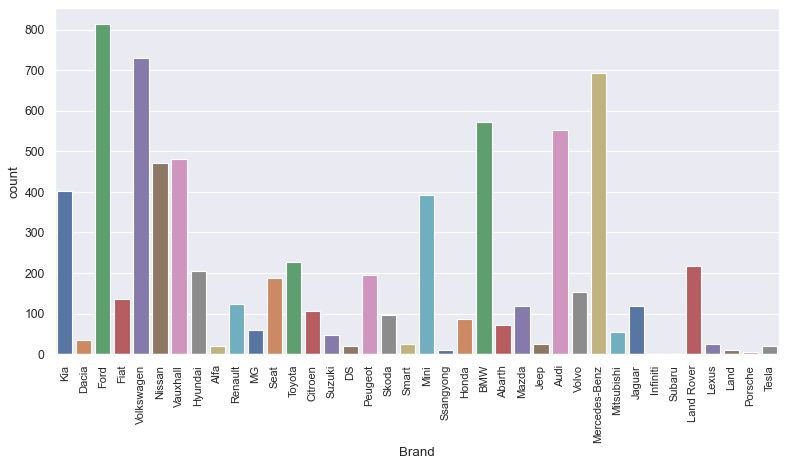

In [36]:
cat_count("Brand",10, 90)

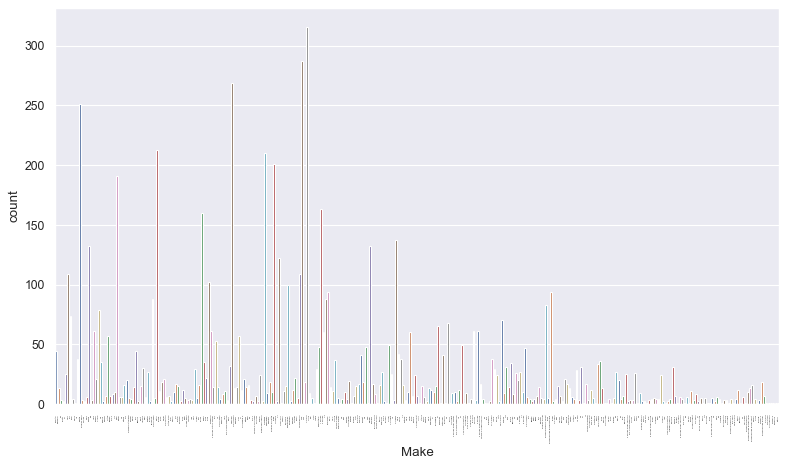

In [37]:
cat_count("Make",2, 90)

Make feature has a high level of cardinality and and an uneven distribution 

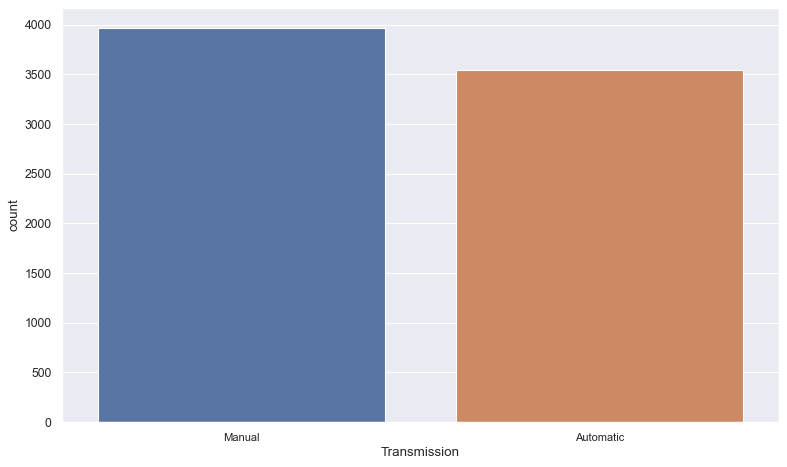

In [155]:
cat_count('Transmission', 10,0)

The transmission types are nearly equal in distribution

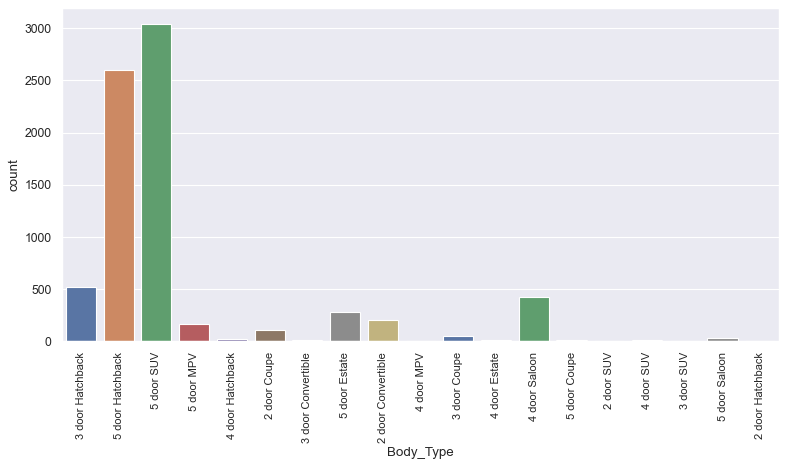

In [156]:
cat_count('Body_Type', 10,90)

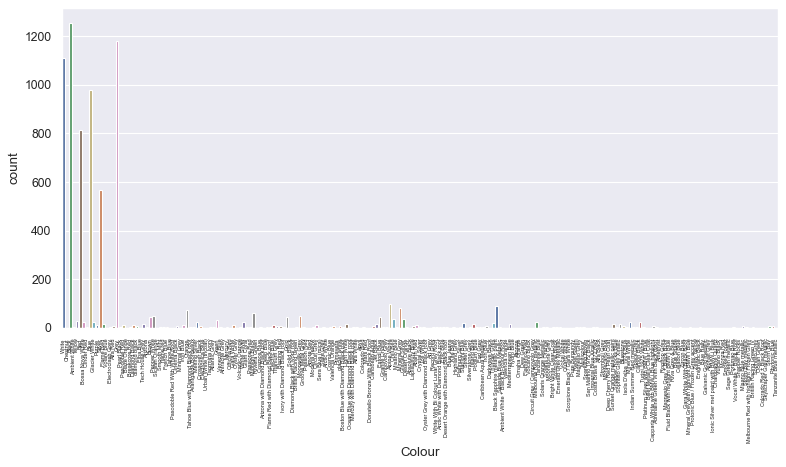

In [158]:
cat_count('Colour', 5,90)

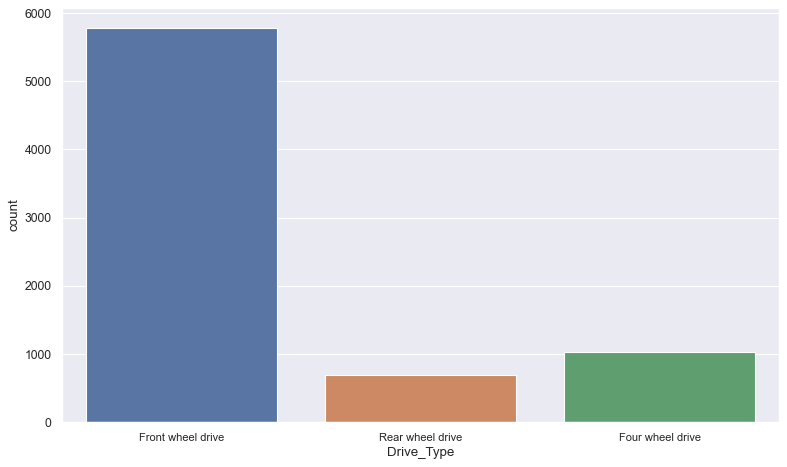

In [163]:
cat_count(cat_features[5], 10,0)

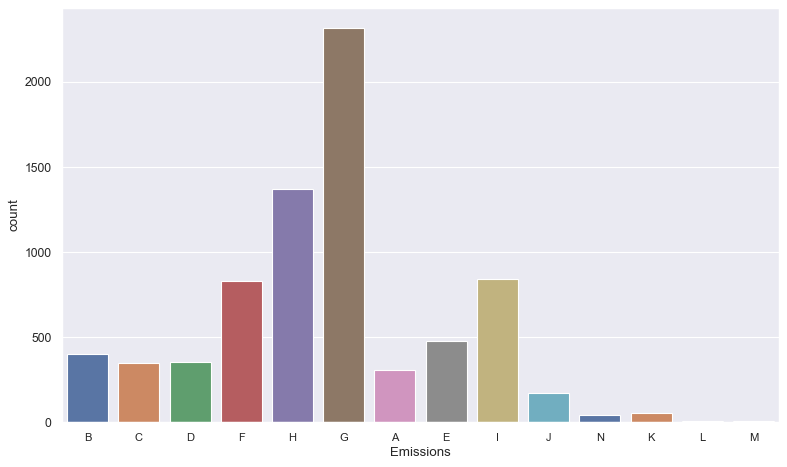

In [164]:
cat_count(cat_features[6], 10,0)

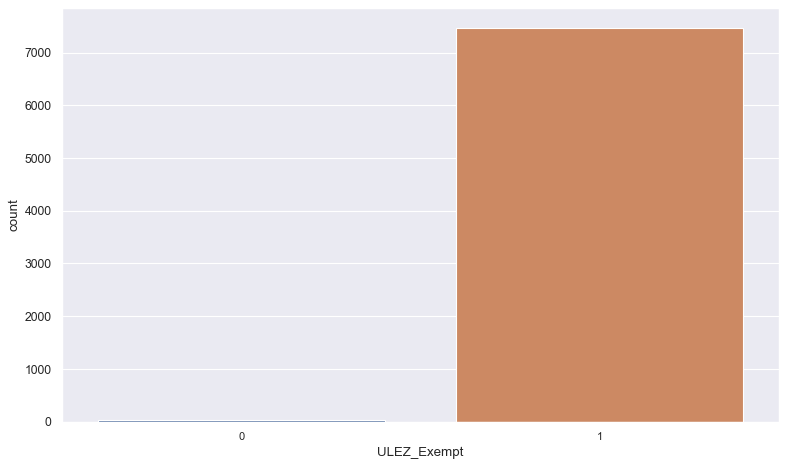

In [165]:
cat_count(cat_features[7], 10,0)

A greater proportion of  cars are ULEZ charge exempt , this column will be removed

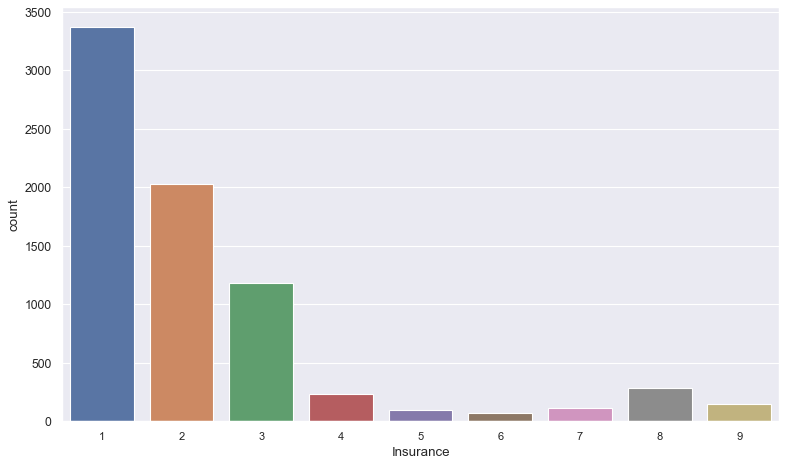

In [166]:
cat_count(cat_features[8], 10,0)

Most of the cars are in insurance group 1-3, however all these insurance groups are similar in price range, with only minor differences, so the insurance category is unlikly to effect price. Statistical Analysis can be used to test this, if there is no significant difference this group can be removed.

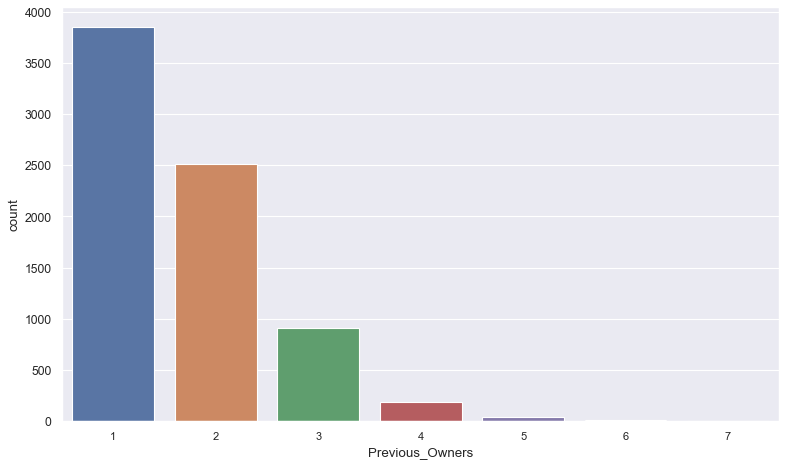

In [167]:
cat_count(cat_features[9], 10,0)

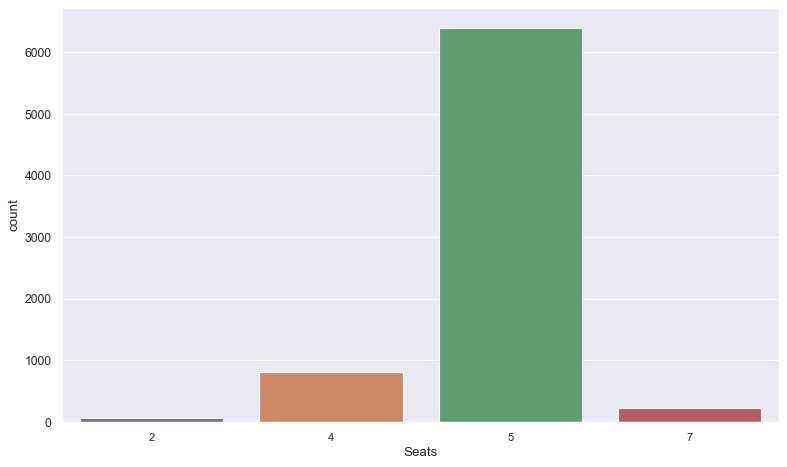

In [168]:
cat_count(cat_features[10], 10,0)

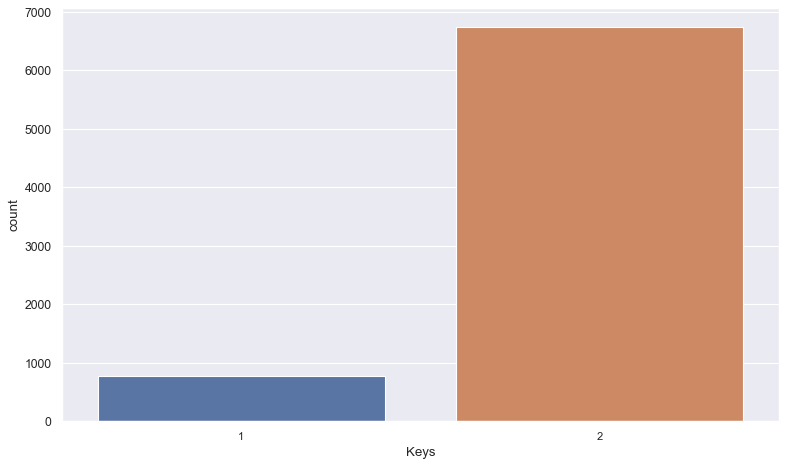

In [169]:
cat_count(cat_features[11], 10,0)

a higher proprtion of cars have 2 or more keys

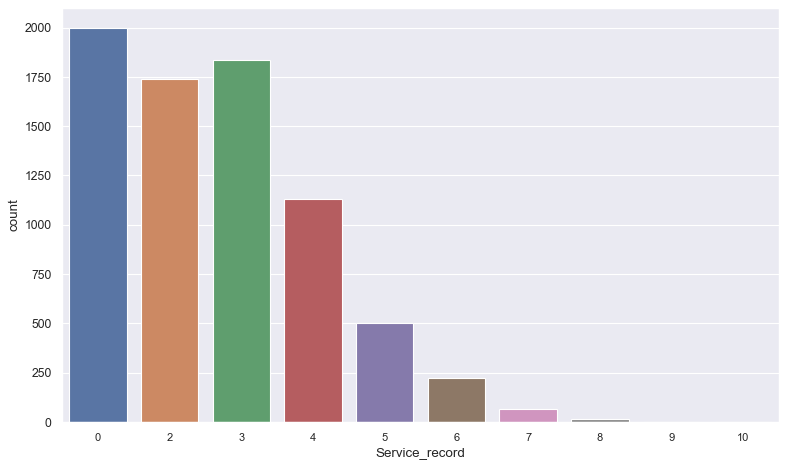

In [170]:
cat_count(cat_features[12], 10,0)

Most of the cars have no service record, its better to turn this into a binary classification showing, full, incomplete or no service record, in order to avoid autocorrelation with year feature.

In [178]:
years = list(df['Year'].values)

In [192]:
service = list(df['Service_record'].values)

In [198]:
age = [2022-year for year in years ]

In [227]:
record = []
for a, s in zip(age,service):
    if (a == s or a<s):
        record.append('full')
    elif (a > s and s != 0):
        record.append('partial')
    elif s == 0:
        record.append('absent')

In [228]:
df.drop(columns = ["Service_record"])
df['Service_record']= record

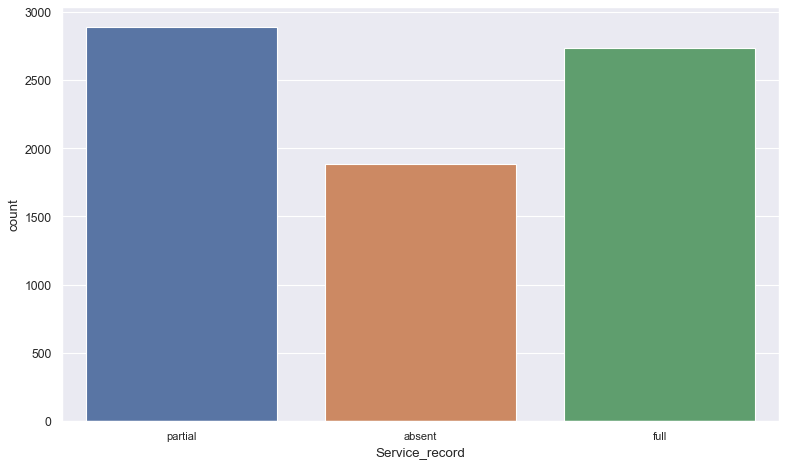

In [229]:
cat_count(cat_features[12], 10,0)

Most of the categorical features except transmission and service record is unbalanced

## Bi-variate analysis

In [253]:
df.head()

,Brand,Make,Year,Mileage,Engine_Size,Transmission,Seats,Body_Type,Colour,Drive_Type,...,Keys,Emissions,ULEZ_Exempt,Top_speed,Accelaration_0_62,Power,Insurance,Mpg,Service_record,Price
0,Kia,Picanto,2015,54990,1.0,Manual,5,3 door Hatchback,White,Front wheel drive,...,1,B,1,98.0,14.4,66.0,2,62.8,partial,5700
1,Dacia,Sandero,2016,24138,0.9,Manual,5,5 door Hatchback,Chestnut,Front wheel drive,...,2,B,1,109.0,11.1,89.0,8,57.7,absent,6250
2,Ford,Ka,2015,30571,1.2,Manual,4,3 door Hatchback,Black,Front wheel drive,...,2,C,1,99.0,13.4,68.0,3,57.7,partial,6300
3,Fiat,Punto,2016,38799,1.2,Manual,5,5 door Hatchback,Ambient White,Front wheel drive,...,1,D,1,97.0,14.4,69.0,8,53.3,partial,6400
4,Volkswagen,up!,2016,58887,1.0,Manual,4,3 door Hatchback,Yellow,Front wheel drive,...,2,B,1,99.0,14.4,59.0,2,62.8,full,6450


### Categorical Data

In [399]:
cat_features

['Brand',
 'Make',
 'Transmission',
 'Body_Type',
 'Colour',
 'Drive_Type',
 'Emissions',
 'ULEZ_Exempt',
 'Insurance',
 'Previous_Owners',
 'Seats',
 'Keys',
 'Service_record']

#### Brand and Price 

In [396]:
def cat_box(feature, fontsize):
    plt.figure(figsize = (15,10))
    plt.title( "Price distribution for each brand")
    brand_box = sns.boxplot(x = feature,y = "Price", data = df, palette = 'bwr')
    brand_box.set_xticklabels(brand_box.get_xticklabels(), rotation=90, fontsize = fontsize)
    plt.tight_layout()
    plt.plot()

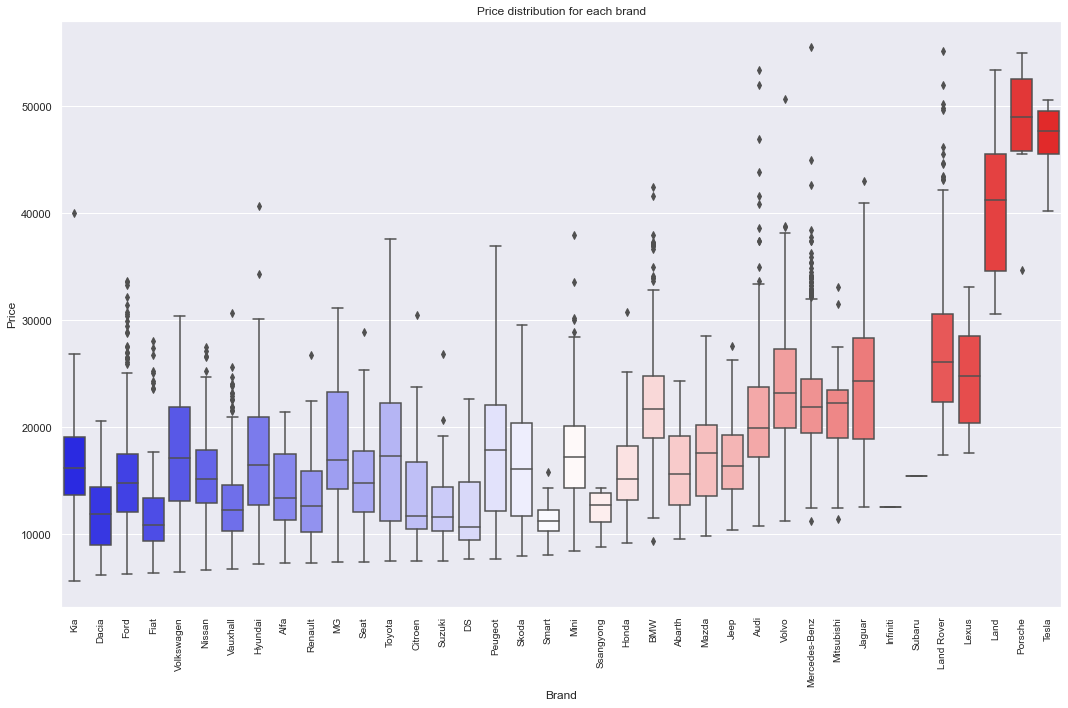

In [397]:
cat_box('Brand',10)

Price ranges for each bran is within similar ranges, except luxury car makes such as porsche and tesla, with some outliers in high price ranges. These high prices are likely due to specifics car models that are more expensive, and should not be treated as anomalies and rather as valid data. Since its likely that price depends on both the brand and the make, a three way anova or a non-parametric equivelant could be more insightful. 

- there is a lack of homogeinty in variances
- the data is non-normally distributed
- Assumptions for one way ANOVA are not met, Kruskall-Wallis test can be used to test the  null hypothesis that car brand has no effect on the price of a vehicle.

In [406]:
def krus_get(feature):
    return stats.kruskal(*[group["Price"].values for name, group in df.groupby(feature)])

In [407]:
krus_get("Brand")

KruskalResult(statistic=2810.77392916644, pvalue=0.0)

According to Kryuskal Wallis test the differences in prices between makes are statistically significant, a post hoc Dunn's test can help determin which makes have a significant difference in prices.

In [532]:
class posthoc_get():
    def __init__(self,feature,*show):
        self.feature = feature
        
    def results_get(self):
        p_values = sp.posthoc_dunn(df, val_col='Price', group_col=self.feature, p_adjust = 'bonferroni')
        return p_values
    def dunn_plot(self):
        p_all = self.results_get()
        fix, ax = plt.subplots(figsize=(12, 6))
        heatmap_args = {'linewidths': 0.2, 'linecolor': 'white', 'clip_on': True, 'square': True,
                'cbar_ax_bbox': [0.75, 0.35, 0.04, 0.3], 'labels' :['p < 0.001', 'p < 0.01', 'p < 0.05', 'NS']}
    
        sp.sign_plot(p_all,**heatmap_args)
    
        plt.show()

In [533]:
brand_dunn = posthoc_get('Brand')

In [534]:
brand_dunn.results_get()

,Abarth,Alfa,Audi,BMW,Citroen,DS,Dacia,Fiat,Ford,Honda,...,Skoda,Smart,Ssangyong,Subaru,Suzuki,Tesla,Toyota,Vauxhall,Volkswagen,Volvo
Abarth,1.000000e+00,1.000000e+00,5.991072e-07,2.834382e-14,1.000000e+00,1.000000e+00,3.069574e-01,1.490622e-04,1.000000e+00,1.000000e+00,...,1.000000e+00,3.481242e-02,1.000000e+00,1.0,2.657651e-01,3.007060e-12,1.000000e+00,3.305998e-04,1.000000e+00,5.635795e-14
Alfa,1.000000e+00,1.000000e+00,5.126460e-03,8.324434e-06,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.0,1.000000e+00,9.177090e-10,1.000000e+00,1.000000e+00,1.000000e+00,1.085477e-06
Audi,5.991072e-07,5.126460e-03,1.000000e+00,1.455369e-03,5.893235e-27,2.302032e-07,3.876635e-15,5.064935e-54,4.455168e-62,1.908406e-10,...,3.901565e-08,1.928819e-14,1.709691e-03,1.0,4.568419e-18,5.272579e-05,8.585160e-11,1.137112e-109,8.185429e-15,2.700771e-03
BMW,2.834382e-14,8.324434e-06,1.455369e-03,1.000000e+00,5.460673e-42,3.461044e-11,4.976626e-22,7.091873e-77,3.926530e-108,1.026236e-19,...,3.943517e-17,3.722060e-20,1.480793e-05,1.0,1.780928e-26,2.165129e-02,1.254669e-25,2.399199e-161,5.726663e-40,1.000000e+00
Citroen,1.000000e+00,1.000000e+00,5.893235e-27,5.460673e-42,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,4.377620e-01,1.000000e+00,1.000000e+00,1.0,1.000000e+00,4.176636e-20,9.932796e-05,1.000000e+00,3.010061e-09,6.312571e-35
DS,1.000000e+00,1.000000e+00,2.302032e-07,3.461044e-11,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.0,1.000000e+00,3.619290e-14,1.979277e-01,1.000000e+00,2.018090e-02,4.577948e-12
Dacia,3.069574e-01,1.000000e+00,3.876635e-15,4.976626e-22,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,9.053991e-01,8.979477e-01,...,6.244249e-02,1.000000e+00,1.000000e+00,1.0,1.000000e+00,2.887852e-19,3.368842e-04,1.000000e+00,2.856370e-06,4.789875e-22
Fiat,1.490622e-04,1.000000e+00,5.064935e-54,7.091873e-77,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.824865e-07,6.110946e-04,...,1.072702e-06,1.000000e+00,1.000000e+00,1.0,1.000000e+00,5.254919e-27,2.885185e-15,1.000000e+00,5.744167e-26,3.563063e-58
Ford,1.000000e+00,1.000000e+00,4.455168e-62,3.926530e-108,1.000000e+00,1.000000e+00,9.053991e-01,1.824865e-07,1.000000e+00,1.000000e+00,...,1.000000e+00,9.827845e-02,1.000000e+00,1.0,6.609584e-01,2.356236e-18,1.554195e-03,3.247434e-13,2.618863e-16,1.018242e-50
Honda,1.000000e+00,1.000000e+00,1.908406e-10,1.026236e-19,1.000000e+00,1.000000e+00,8.979477e-01,6.110946e-04,1.000000e+00,1.000000e+00,...,1.000000e+00,1.026288e-01,1.000000e+00,1.0,8.291857e-01,7.765972e-14,1.000000e+00,1.311805e-03,9.686425e-01,3.333376e-18


TypeError: set_ticks() got an unexpected keyword argument 'labels'

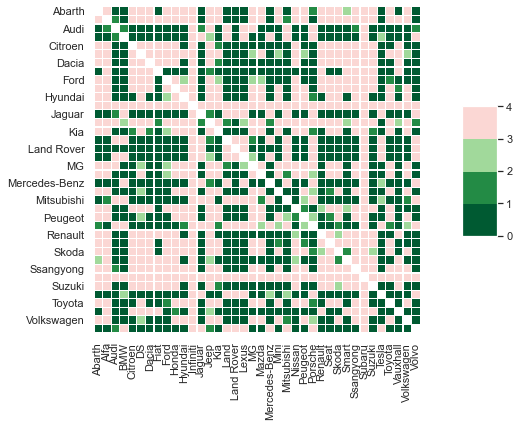

In [535]:
brand_dunn.dunn_plot()

The above matrix plot highlights,in pink, all the cases where the difference between two car brands is not significant. If cardinality needs to be reduced I can use this plot to decide what brands can be combined.

### Brand vs Price

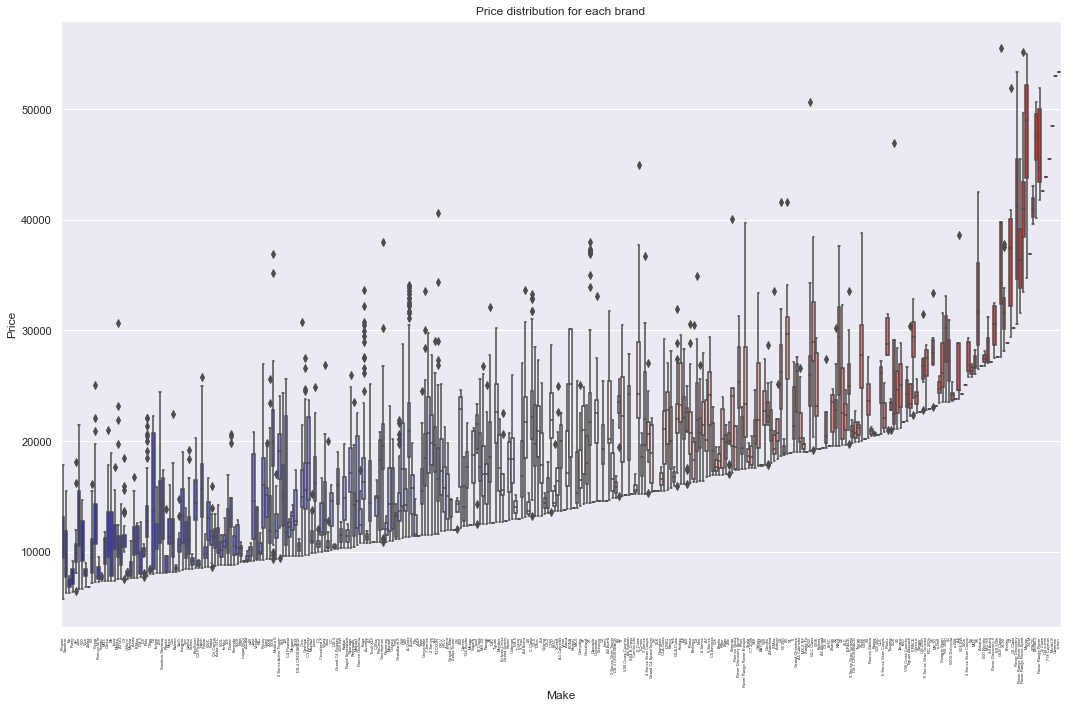

In [398]:
cat_box('Make',4)

In [395]:
stats.kruskal(*[group["Price"].values for name, group in df.groupby("Make")])

KruskalResult(statistic=5003.963505884061, pvalue=0.0)

There is a significant effect on price by the make of the car, however the high cardinality makes it difficult to ascertain the post hic results. I will fit initial models before deciding if its worth looking at this feature in more detail. Featur importance can be used to find the inportance of this model.

In [400]:
cat_features

['Brand',
 'Make',
 'Transmission',
 'Body_Type',
 'Colour',
 'Drive_Type',
 'Emissions',
 'ULEZ_Exempt',
 'Insurance',
 'Previous_Owners',
 'Seats',
 'Keys',
 'Service_record']

#### Transmission v Price

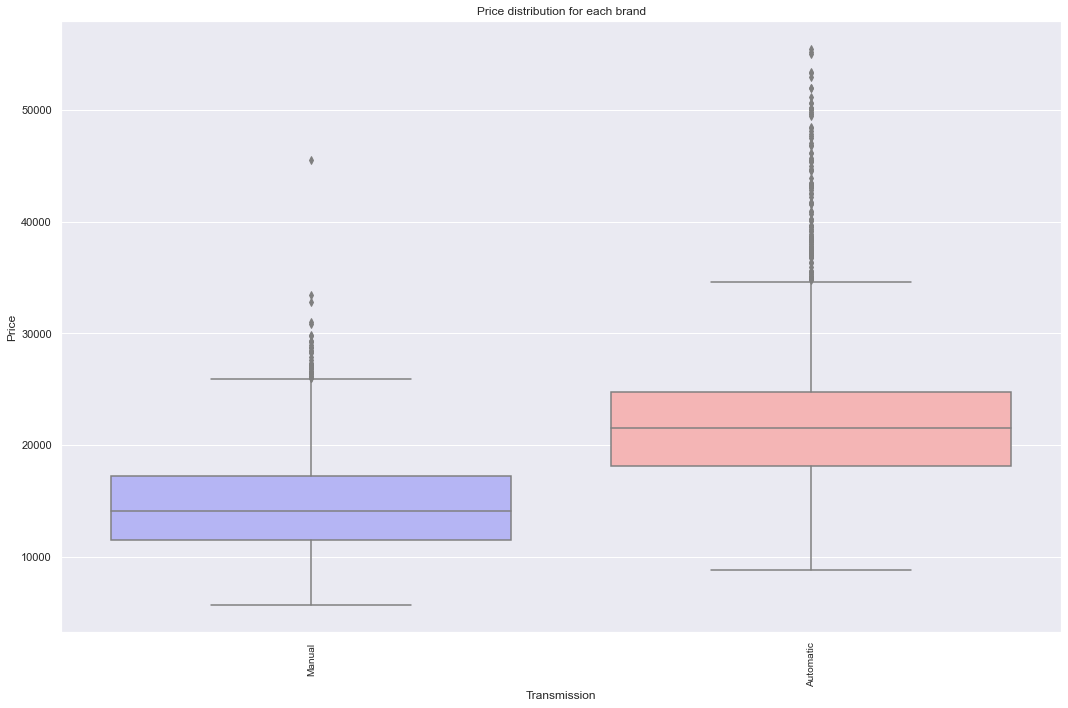

In [401]:
cat_box('Transmission', 10)

In [444]:
krus_get('Transmission')


KruskalResult(statistic=2887.5642707858588, pvalue=0.0)

#### car body vs price

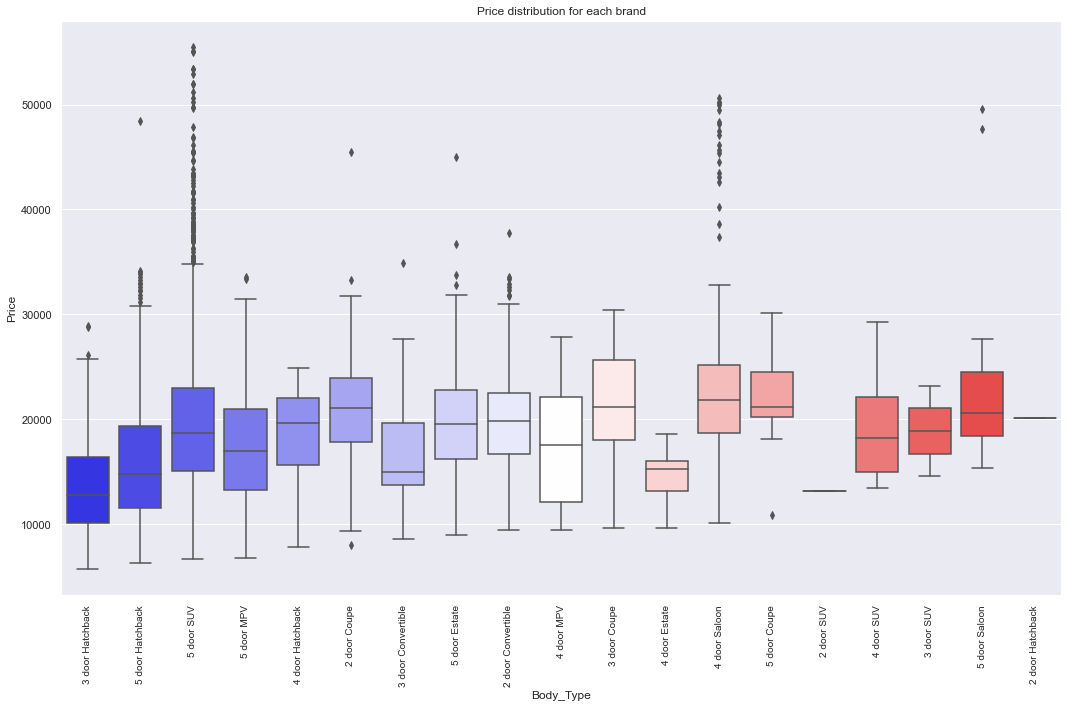

In [403]:
cat_box('Body_Type',10)

In [537]:
body_dunn = posthoc_get('Body_Type')

TypeError: set_ticks() got an unexpected keyword argument 'labels'

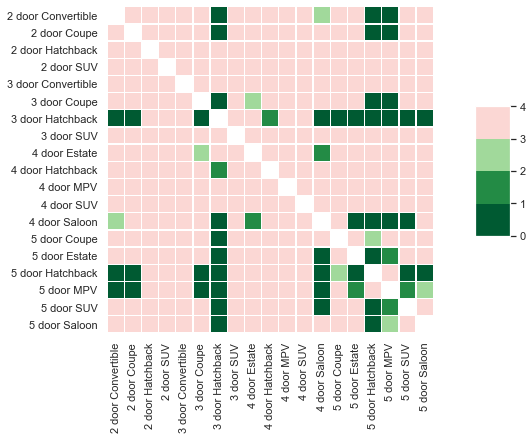

In [538]:
body_dunn.dunn_plot()

In [445]:
cat_features

['Brand',
 'Make',
 'Transmission',
 'Body_Type',
 'Colour',
 'Drive_Type',
 'Emissions',
 'ULEZ_Exempt',
 'Insurance',
 'Previous_Owners',
 'Seats',
 'Keys',
 'Service_record']

In [448]:
k_tests = list(map(krus_get,cat_features))

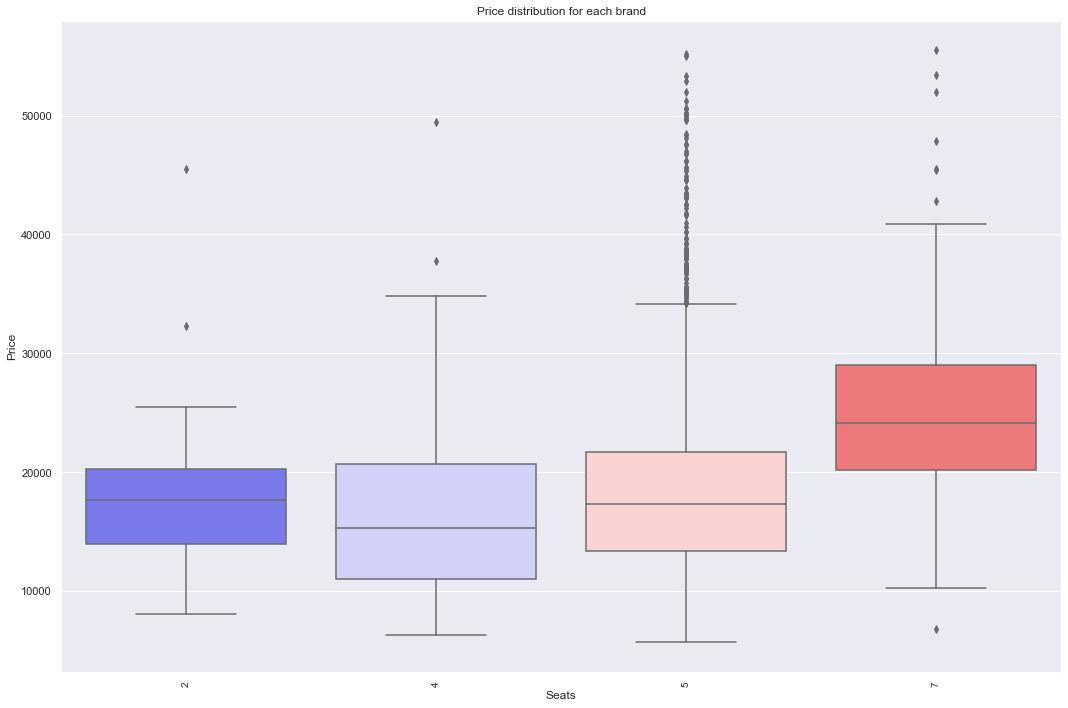

In [496]:
cat_box('Seats',10)

In [541]:
seat_dunn = posthoc_get('Seats')

TypeError: set_ticks() got an unexpected keyword argument 'labels'

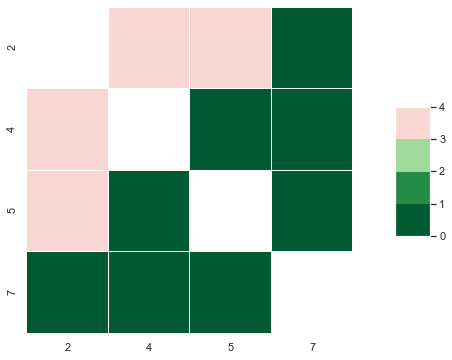

In [542]:
seat_dunn.dunn_plot()

In [454]:
np.column_stack((cat_features, k_tests))

array([['Brand', '2810.77392916644', '0.0'],
       ['Make', '5003.963505884061', '0.0'],
       ['Transmission', '2887.5642707858588', '0.0'],
       ['Body_Type', '1219.4340852376233', '7.664529125282969e-248'],
       ['Colour', '1008.193798349765', '3.827637916865988e-103'],
       ['Drive_Type', '1681.6444243335834', '0.0'],
       ['Emissions', '1356.9327900406058', '2.907398845335184e-282'],
       ['ULEZ_Exempt', '9.16493954067184', '0.0024669578514405197'],
       ['Insurance', '2452.415348759937', '0.0'],
       ['Previous_Owners', '175.15741416802078', '3.620218695959076e-35'],
       ['Seats', '269.6241826069499', '3.721979774342795e-58'],
       ['Keys', '0.4939686570956703', '0.4821622983413275'],
       ['Service_record', '93.94065641896391', '3.9906684308237076e-21']],
      dtype='<U32')

The only feature that lacks a significant effect on prices are the number of keys, which is quite obvious.

## Continous features

Since the data is not normally distributed and outliers are prelevant I shall use spearmans rank coefficent to analyse the relationship between each continous varaible adn the price.

In [455]:
continous

['Accelaration_0_62',
 'Engine_Size',
 'Power',
 'Mileage',
 'Year',
 'Mpg',
 'Top_speed']

In [474]:
def rho_get(feature):
    data = df[[feature,'Price']].dropna()
    return stats.spearmanr(data[feature],data['Price'])

In [475]:
rho_get('Accelaration_0_62')

SpearmanrResult(correlation=-0.620403097079058, pvalue=0.0)

In [476]:
rho_tests = list(map(rho_get,continous))

In [477]:
np.column_stack((continous, rho_tests))

array([['Accelaration_0_62', '-0.620403097079058', '0.0'],
       ['Engine_Size', '0.5833387742756272', '0.0'],
       ['Power', '0.7170375964232215', '0.0'],
       ['Mileage', '-0.09266140168490641', '8.589189947881152e-16'],
       ['Year', '0.34926772166160874', '2.237032861142059e-214'],
       ['Mpg', '-0.32643368220562385', '1.1435840907330524e-182'],
       ['Top_speed', '0.5359329772720302', '0.0']], dtype='<U32')

Each variable has a significant effect on the price of a car, with power and accelaration having the greatest effect, given that accelaration has 298 missing values removing this feature could have a negative impact on the predictive power of a model, however this depends on the colinearty of varaibles.

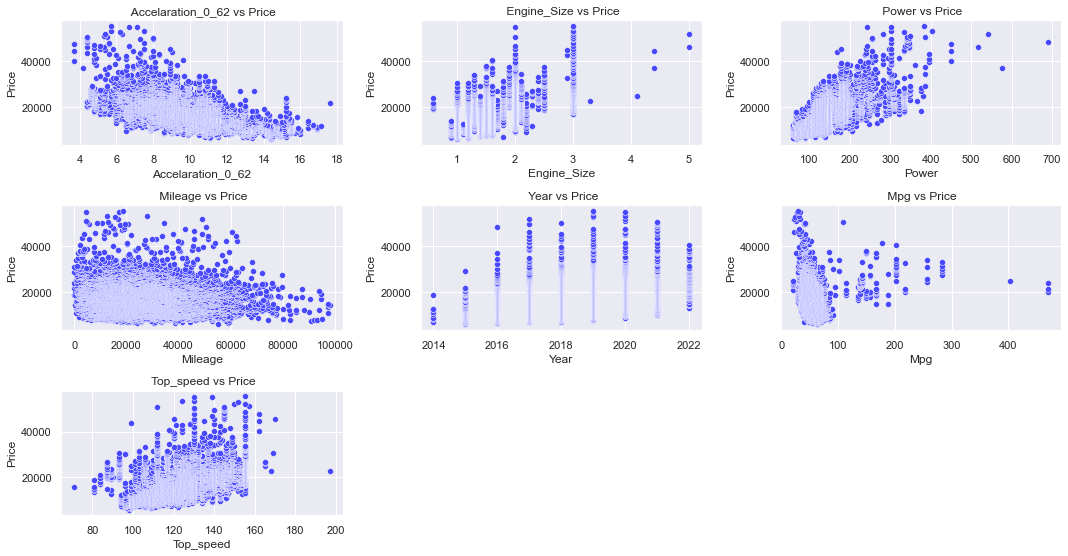

In [473]:
plt.figure(figsize = (15,10))
for i,col in enumerate(df[continous]):
    plt.subplot(4,3,i+1)
    plt.title(f" {col} vs Price")
    sns.scatterplot(x = col, y = "Price", data = df)
    plt.tight_layout()
    plt.plot()

## Multivariate analysis

<Figure size 1080x720 with 0 Axes>

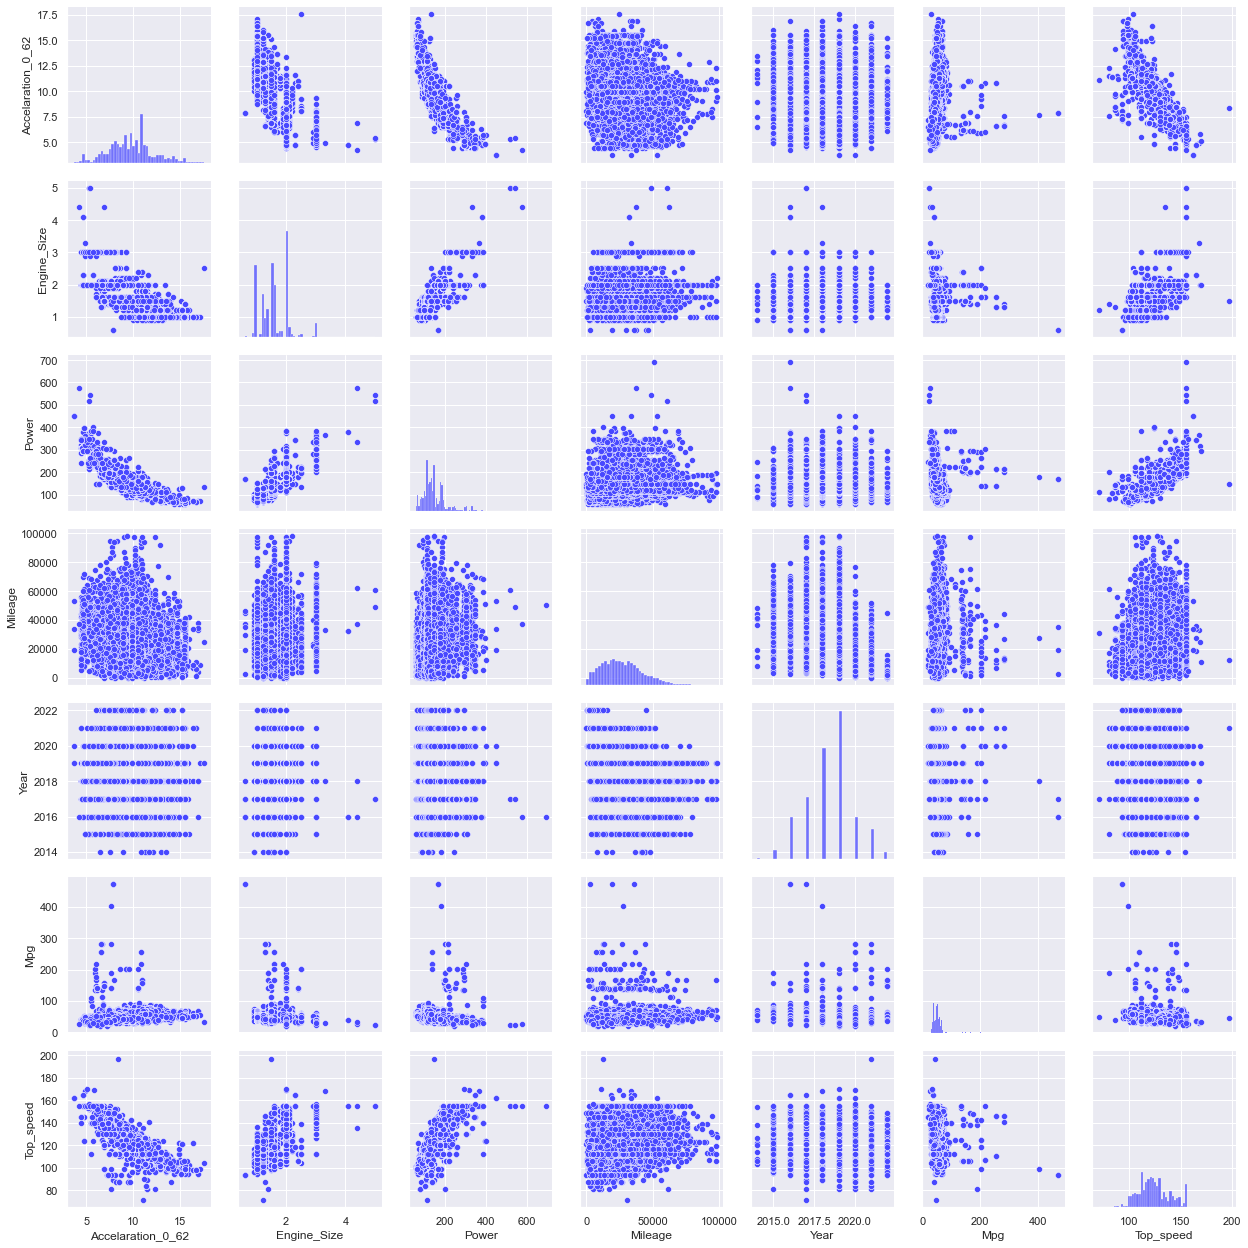

In [479]:
plt.figure(figsize = (15,10))
sns.pairplot(df[continous])
plt.tight_layout()
plt.show()

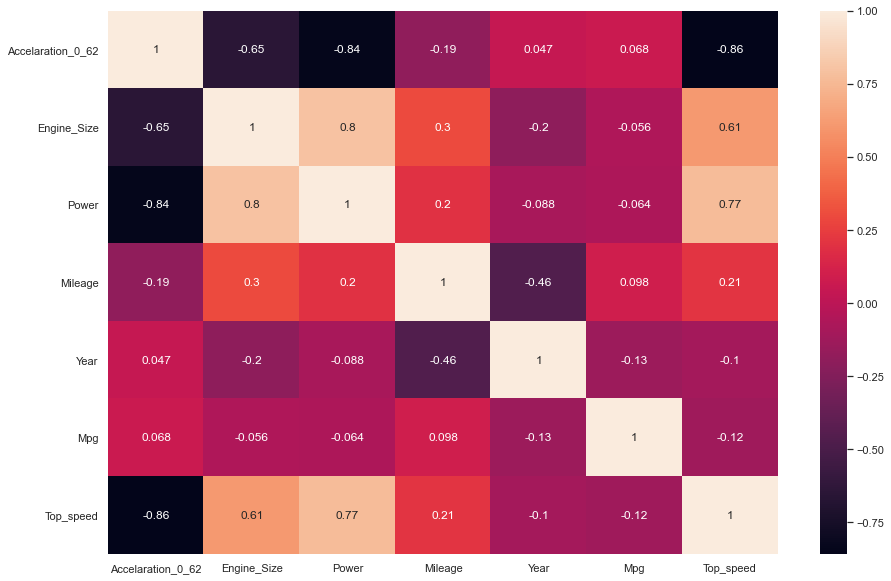

In [480]:
plt.figure(figsize = (15,10))
df_corr = df[continous].corr()
sns.heatmap(df_corr, annot = True)
plt.show()

Highly Correlated features
- Top_speed and Accelaration
- Power and Accelaration
- Engine_size and Accelaration
- Power and Accelaration

Hear accelaration is highly correlated with several features, given its high number of missing values, it would be possible to remove this varaible from a model.

## Missing Values

In [233]:
df[cat_cols].isnull().sum()

Brand           0
Make            0
Transmission    0
Body_Type       0
Colour          0
Drive_Type      1
Registration    0
Emissions       0
dtype: int64

Only one missing value in categorical variables, for DriveType. This can be easily imputed via google search.

In [238]:
df[df["Drive_Type"].isnull()] # Lexus UX250h is a front wheel drive so impute

,Brand,Make,Year,Mileage,Engine_Size,Transmission,Seats,Body_Type,Colour,Drive_Type,...,Keys,Emissions,ULEZ_Exempt,Top_speed,Accelaration_0_62,Power,Insurance,Mpg,Service_record,Price
6849,Lexus,UX 250h,2019,39734,2.0,Automatic,5,5 door Estate,Silver,<NA>,...,2,E,1,110.0,8.7,181.0,2,50.4,full,26450


In [244]:
df["Drive_Type"][df["Drive_Type"].isnull()] = 'Front wheel drive'

In [246]:
num_cols.isnull().sum()

Year                   0
Mileage                0
Engine_Size          128
Seats                  0
Previous_Owners        0
Keys                   0
ULEZ_Exempt            0
Top_speed              8
Accelaration_0_62    265
Power                  0
Insurance              0
Mpg                  134
Service_record         0
dtype: int64

In [247]:
df[["Year","Make","Brand","Engine_Size","Transmission"]][df["Engine_Size"].isnull()]

,Year,Make,Brand,Engine_Size,Transmission
1529,2017,Leaf,Nissan,NaN,Automatic
1932,2017,fortwo,Smart,NaN,Automatic
2335,2017,Leaf,Nissan,NaN,Automatic
2346,2019,fortwo,Smart,NaN,Automatic
3051,2020,fortwo,Smart,NaN,Automatic
...,...,...,...,...,...
7494,2021,Model 3,Tesla,NaN,Automatic
7495,2021,Model 3,Tesla,NaN,Automatic
7496,2021,Model 3,Tesla,NaN,Automatic
7498,2021,Model 3,Tesla,NaN,Automatic


The engine size is missing for electric cars , this is structurally missing data. zero can be used to replaced to the values however I will test wether this leads to issues.  The missing data for Mpg has the same issue.

In [490]:
df[["Year","Make","Brand","Engine_Size","Transmission"]][df["Mpg"].isnull()]

,Year,Make,Brand,Engine_Size,Transmission
1529,2017,Leaf,Nissan,NaN,Automatic
1932,2017,fortwo,Smart,NaN,Automatic
2335,2017,Leaf,Nissan,NaN,Automatic
2346,2019,fortwo,Smart,NaN,Automatic
3051,2020,fortwo,Smart,NaN,Automatic
...,...,...,...,...,...
7494,2021,Model 3,Tesla,NaN,Automatic
7495,2021,Model 3,Tesla,NaN,Automatic
7496,2021,Model 3,Tesla,NaN,Automatic
7498,2021,Model 3,Tesla,NaN,Automatic


In [494]:
df["Make"][df["Mpg"].isnull()].unique()

<StringArray>
[        'Leaf',       'fortwo',          'Zoe',        'IONIQ',
          'Mii',           'i3',         'Soul',        'MG ZS',
         'Golf',      'Corsa-e',        'MX-30',   'Countryman',
       'e-Golf',        'e-208',          '208',         '500e',
          'MG5',     '5 Series', '500 Electric',     'Electric',
         'KONA',        'Mokka',       'I-PACE',      'Model 3',
    'Q4 e-tron',      'Model S',       'e-tron']
Length: 27, dtype: string

All mpg missing values also pertain to electric cars

In [1136]:
df[["Year","Make","Brand","Engine_Size","Transmission"]][df["Accelaration_0_62"].isnull()]

,Year,Make,Brand,Engine_Size,Transmission
25,2017,Corsa,Vauxhall,1.4,Manual
84,2016,Astra,Vauxhall,1.6,Manual
86,2016,Corsa,Vauxhall,1.4,Manual
112,2016,Insignia,Vauxhall,1.6,Manual
122,2017,Tipo,Fiat,1.4,Manual
...,...,...,...,...,...
7228,2018,GLC Class,Mercedes-Benz,2.1,Automatic
7303,2019,UX 250h,Lexus,2.0,Automatic
7316,2020,GLA Class,Mercedes-Benz,1.3,Automatic
7338,2019,E Class,Mercedes-Benz,1.9,Automatic


Accelaration data for cars are missing, this is missing at random, the data can be imputed, since the data for accelartion ofr these models can be obtained via research. However since this is a large number of values, it will require another scraper, before deciding on this task, I will check wether a model can be fitted without this feature, and check the feature importances in XGBoost.

in top speed there only 8 missing values this can be easliy imputed using google serach manually

In [249]:
df[["Year","Make","Brand","Engine_Size","Transmission"]][df["Top_speed"].isnull()] 

,Year,Make,Brand,Engine_Size,Transmission
3209,2022,i10,Hyundai,1.2,Automatic
4688,2016,XC60,Volvo,2.0,Automatic
4993,2021,Juke,Nissan,1.0,Manual
6880,2022,C-HR,Toyota,1.8,Automatic
6882,2021,2 Series,BMW,2.0,Automatic
6922,2021,TUCSON,Hyundai,1.6,Automatic
6947,2022,IONIQ,Hyundai,NaN,Automatic
7191,2019,Q5,Audi,2.0,Automatic


In [250]:
top_nan_index = np.where(df["Top_speed"].isnull())[0].tolist() # list of row indexes for topspeed Nan Values
nan_replace = [106,130,112,105,155,117,103,130] # replacement values obtained through google search
for i in top_nan_index:
    for r in nan_replace:
        df.loc[i,"Top_speed"] = r

In [251]:
df["Top_speed"].isnull().sum()

0

## Model Fitting

So far the EDA has revealed that the data is non-normally distributed and has a high degree of cardinality in two categorical variables, making one hot encoding unfeasable due to a balooning in dimensionality. Making Label Encoding the only viable option, this requires the use of a model that does not infer ordinality from label encoded data, such as random forest regression or support vector machines (SVM).

There are multiple variables that have no significant effect, these can be removed, but first I will include them in a initial model. 
Accelartion, engine_size and Mpg. Since accelartion and mpg are autocorrelated and correlated with power which has no missing values, both these varaibles can be represented by power. 

Initial model fitting will use a random forest regressor with label encoded data.

In [484]:
'''LabelEncoder() can only take a 1d array as an argument, this module will be able to a dataframe and label encode all columns 
   with string or object dtype'''


class Multiple_Encoder_Label:
    def __init__(self,data):
        self.data = data
        self.le = LabelEncoder()
        self.str_col = data.select_dtypes(include = ['object','string']).columns.to_list()
        self.all_cols = data.columns.to_list()
        
    def encode(self):
        done = {}
        for col in self.all_cols:
            if col in self.str_col:
                coded = self.le.fit_transform(self.data[col])
                done[col] = coded
            
            else:
                done[col] = self.data[col]

        return pd.DataFrame(done)


In [485]:
df_tree = Multiple_Encoder_Label(df).encode()

In [487]:
df_tree.head()

,Brand,Make,Year,Mileage,Engine_Size,Transmission,Seats,Body_Type,Colour,Drive_Type,...,Keys,Emissions,ULEZ_Exempt,Top_speed,Accelaration_0_62,Power,Insurance,Mpg,Service_record,Price
0,14,190,2015,54990,1.0,1,5,6,204,1,...,1,1,1,98.0,14.4,66.0,2,62.8,2,5700
1,6,236,2016,24138,0.9,1,5,15,46,1,...,2,1,1,109.0,11.1,89.0,8,57.7,0,6250
2,8,148,2015,30571,1.2,1,4,6,22,1,...,2,2,1,99.0,13.4,68.0,3,57.7,2,6300
3,7,197,2016,38799,1.2,1,5,15,7,1,...,1,3,1,97.0,14.4,69.0,8,53.3,2,6400
4,36,308,2016,58887,1.0,1,4,6,207,1,...,2,1,1,99.0,14.4,59.0,2,62.8,1,6450


In [594]:
target = "Price"
X_tree= df_tree[df_tree.columns.to_list()]
X_tree =X_tree.drop(columns = target)
y = df_tree[target]

#### Removing Acceleration, Mpg, ,Keys,imputing 0 to missing engine_size values

In [650]:
X_tree1 = X_tree[:].drop(columns = ['Accelaration_0_62','Mpg','Keys','Registration'])
X_tree1['Engine_Size'].fillna(0,inplace = True)

In [651]:
X_tree1

,Brand,Make,Year,Mileage,Engine_Size,Transmission,Seats,Body_Type,Colour,Drive_Type,Previous_Owners,Emissions,ULEZ_Exempt,Top_speed,Power,Insurance,Service_record
0,14,190,2015,54990,1.0,1,5,6,204,1,2,1,1,98.0,66.0,2,2
1,6,236,2016,24138,0.9,1,5,15,46,1,3,1,1,109.0,89.0,8,0
2,8,148,2015,30571,1.2,1,4,6,22,1,3,2,1,99.0,68.0,3,2
3,7,197,2016,38799,1.2,1,5,15,7,1,4,3,1,97.0,69.0,8,2
4,36,308,2016,58887,1.0,1,4,6,207,1,2,1,1,99.0,59.0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7504,2,298,2020,12494,0.0,0,5,17,22,0,1,0,1,124.0,402.0,4,0
7505,15,216,2019,28024,3.0,0,7,17,133,0,1,10,1,130.0,302.0,4,1
7506,25,167,2020,4706,2.0,0,5,17,165,0,1,11,1,139.0,242.0,4,0
7507,16,221,2019,17338,3.0,0,5,17,204,0,1,9,1,130.0,302.0,4,2


In [652]:
class modeller:
    def __init__(self,split_n,model,X,y):
        self.mse_all = []
        self.model = model
        self.X = X
        self.y =y
        self.kf=ShuffleSplit(n_splits=split_n, test_size=.25, random_state=0)
        self.y_pred = []
        self.y_valid = []
        self.y_train = []
        
    def split_train_test(self):
        for fold , (trn_,val_) in enumerate(self.kf.split(X=self.X,y=self.y)):
            
            X_train=self.X.iloc[trn_]
            y_train=self.y.iloc[trn_]
        
            X_valid=self.X.iloc[val_]
            y_valid=self.y.iloc[val_]
        
            
            self.model.fit(X_train,y_train)
            y_pred=self.model.predict(X_valid)
            print(f"The fold is : {fold} : ")
            mse = mean_squared_error(y_valid,y_pred)
        
            print(f"The MSE for {fold+1} : {mse}")
            self.mse_all.append(mse)
            
            self.y_pred.append(y_pred)
            self.y_valid.append(y_valid)
            self.y_train.append(y_train)
        
    def metrics(self):
        mean = np.mean(self.mse_all)
        std = np.std(self.mse_all)
        rmse = np.sqrt(mean)
        
        return {'RMSE': rmse, 'Std RMSE': np.sqrt(std)}
    
    def feature_importance(self, model_name):
        plt.figure(figsize=(15,5))
        importance = self.model.feature_importances_
        idxs = np.argsort(importance)
        plt.title("Feature Importance")
        plt.barh(range(len(idxs)),importance[idxs],align="center")
        plt.yticks(range(len(idxs)),[self.X.columns.to_list()[i] for i in idxs])
        plt.xlabel(f"{model_name} Feature Importance")
        plt.tight_layout()
        plt.show()
    def preds_y(self):
        ys = pd.DataFrame({"Predicted": self.y_pred, "Actual": self.y_valid})
        return ys
    def train_y(self):
        return pd.DataFrame({"Train": self.y_train})
    
    def target_distplots(self):
        sns.set_theme(style="darkgrid")
        plt.figure(figsize = (15,15))
        
        rf_ys =self.preds_y()
        training_y = self.train_y()
        
        for i in range(5):
            plt.subplot(3,3,i+1)
            plt.title(f"Fold {i+1}")
            predicted = pd.Series(rf_ys.loc[i,"Predicted"])
            test = pd.Series(rf_ys.loc[i,"Actual"])
            train =training_y.loc[i, "Train"]
            sns.histplot(x=predicted, label = "Predicted Target" , kde=True, color="blue")
            sns.histplot(x=test,label = 'Validation Target',  kde=True,color="red")
            sns.histplot(x=train,label = 'Training Target',  kde=True,color="gray")
        plt.legend()
        plt.show()

### Random Forest Regression

In [653]:
rf =modeller(5,RandomForestRegressor(), X_tree1 ,y)

In [654]:
rf.split_train_test()

The fold is : 0 : 
The MSE for 1 : 3880259.320021299
The fold is : 1 : 
The MSE for 2 : 3686684.7912673056
The fold is : 2 : 
The MSE for 3 : 3741229.3182907347
The fold is : 3 : 
The MSE for 4 : 3950410.319488818
The fold is : 4 : 
The MSE for 5 : 3504988.098109691


In [655]:
rf.metrics()

{'RMSE': 1937.1923935003383, 'Std RMSE': 394.58763641977436}

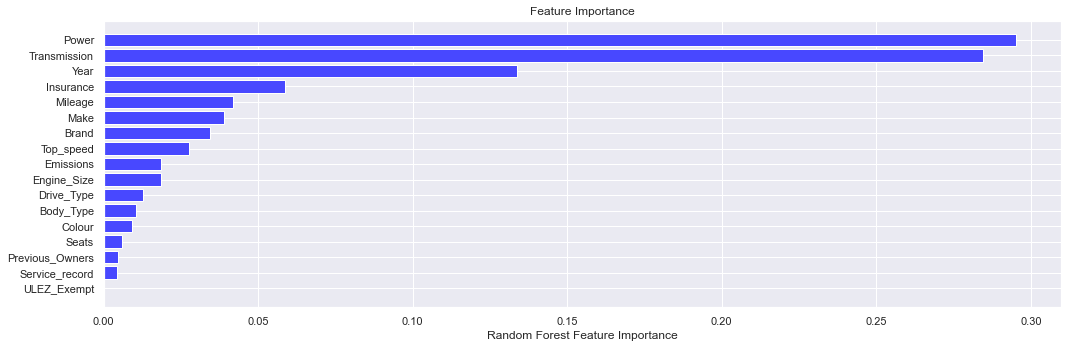

In [656]:
rf.feature_importance('Random Forest')

Transmission is the most important feature in model, ULEZ_Exempt level is the least important

#### Removing Emissions

In [657]:
X_tree2 = X_tree1.drop(columns = 'ULEZ_Exempt')

In [658]:
rf2 =modeller(5,RandomForestRegressor(),X_tree2,y)

In [659]:
rf2.split_train_test()

The fold is : 0 : 
The MSE for 1 : 3861546.046059638
The fold is : 1 : 
The MSE for 2 : 3589067.451943557
The fold is : 2 : 
The MSE for 3 : 3749837.1046325876
The fold is : 3 : 
The MSE for 4 : 3935222.1817092653
The fold is : 4 : 
The MSE for 5 : 3638235.3458466455


In [660]:
rf2.metrics()

{'RMSE': 1937.7258903256513, 'Std RMSE': 361.11503639829976}

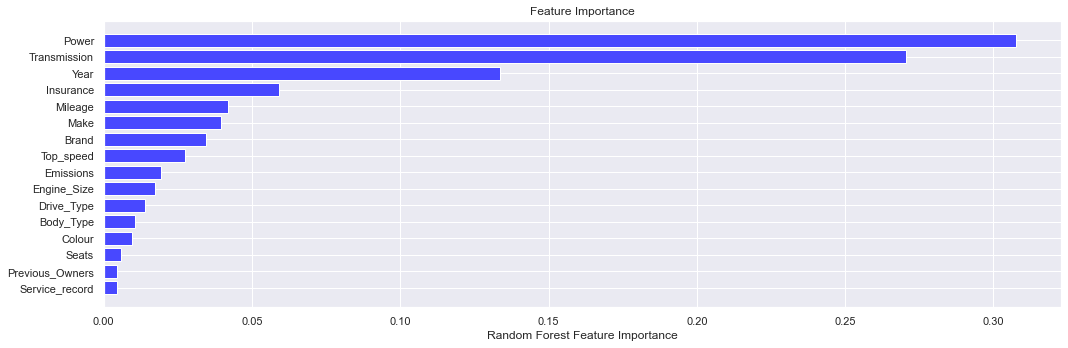

In [661]:
rf2.feature_importance('Random Forest')

No significant difference in RMSE with removal of ULEZ_exempt. I will attempt to remove Seats,Previous_Owners, and Service_record

In [662]:
X_tree3 = X_tree2.drop(columns = ['Colour','Seats','Previous_Owners','Service_record'])

In [663]:
rf3 = modeller(5,RandomForestRegressor(),X_tree3,y)

In [664]:
rf3.split_train_test()

The fold is : 0 : 
The MSE for 1 : 3783423.618876464
The fold is : 1 : 
The MSE for 2 : 3619443.908146965
The fold is : 2 : 
The MSE for 3 : 3639616.466054313
The fold is : 3 : 
The MSE for 4 : 3800686.581336528
The fold is : 4 : 
The MSE for 5 : 3447499.1110223643


In [665]:
rf3.metrics()

{'RMSE': 1912.624881435805, 'Std RMSE': 358.1040801932735}

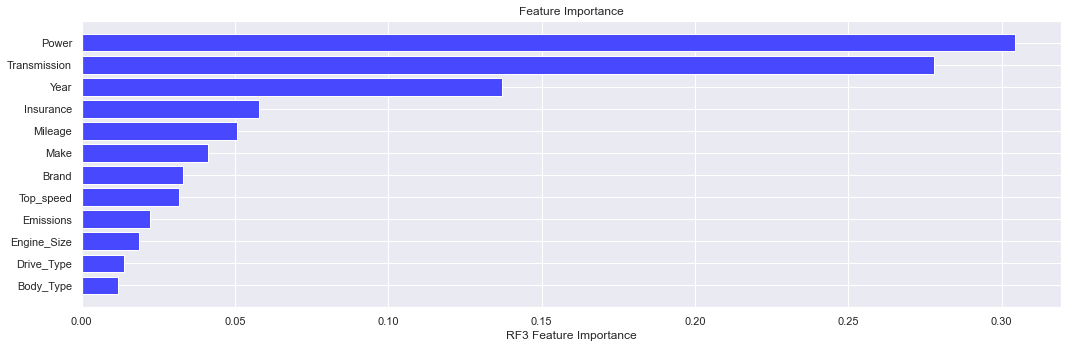

In [666]:
rf3.feature_importance('RF3')

No loss in accuracy, slight imporovement, the model shall only use these features.

### XGBoost

In [667]:
import xgboost as xgb

In [668]:
X_train, X_test, y_train, y_test = train_test_split(X_tree3, y, test_size=0.20, random_state=42)
xgb_r= xgb.XGBRegressor(missing = np.NaN)
xgb_r.fit(X_train,y_train)
y_pred = xgb_r.predict(X_test)
mse_xgb = mean_squared_error(y_test,y_pred)
print(f"mean squared error {mse_xgb}")
print(f"RMSE: {mse_xgb ** (1/2)}" )

mean squared error 3207895.750691126
RMSE: 1791.0599517300157


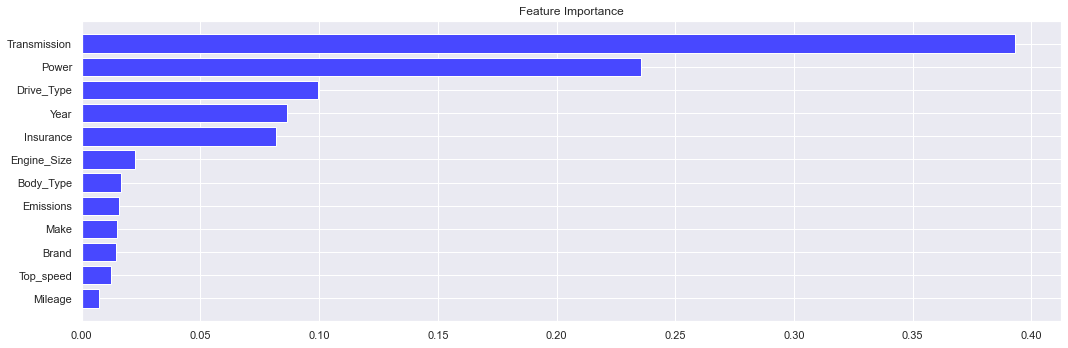

In [671]:

plt.figure(figsize=(15,5))
importance = xgb_r.feature_importances_
idxs = np.argsort(importance)
plt.title("Feature Importance")
plt.barh(range(len(idxs)),importance[idxs],align="center")
plt.yticks(range(len(idxs)),[X_tree3.columns.to_list()[i] for i in idxs])

plt.tight_layout()
plt.show()

The most accurate model is the XGBoost 

## Grid Search model tuning

In [676]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [677]:
xgb_r.get_params(deep=True) # parameters for best performing model so far

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_bin': 256,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 6,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [728]:
params = { 'max_depth': [None],
           'learning_rate': [0.4],
           'n_estimators': [200],
           }

xgbr = xgb.XGBRegressor(seed = 20)

clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1)
clf.fit(X_tree3, y)
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters: {'learning_rate': 0.4, 'max_depth': None, 'n_estimators': 200}
Lowest RMSE:  3800.6018000162558


In [729]:
clf.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.4, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=200, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=20,
             reg_alpha=0, reg_lambda=1, ...)

In [732]:
X_train, X_test, y_train, y_test = train_test_split(X_tree3, y, test_size=0.20, random_state=42)
xgb_r= clf.best_estimator_
xgb_r.fit(X_train,y_train)
y_pred = xgb_r.predict(X_test)
mse_xgb = mean_squared_error(y_test,y_pred)
print(f"mean squared error {mse_xgb}")
print(f"RMSE: {mse_xgb ** (1/2)}" )

mean squared error 3503402.1791436127
RMSE: 1871.737743153034


In [717]:
X_train, X_test, y_train, y_test = train_test_split(X_tree3, y, test_size=0.20, random_state=42)

rf_new= RandomForestRegressor()
rf_new.fit(X_train,y_train)
y_pred = rf_new.predict(X_test)
mse_xgb = mean_squared_error(y_test,y_pred)
print(f"mean squared error {mse_xgb}")
print(f"RMSE: {mse_xgb ** (1/2)}" )

mean squared error 3592985.850033289
RMSE: 1895.5173040711838


In [683]:
rf_new.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [691]:
X_train, X_test, y_train, y_test = train_test_split(X_tree3, y, test_size=0.20, random_state=42)

In [711]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [20,30],
    'max_features': [5,6],
    'min_samples_leaf': [2,3, 4],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [50,100]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Lowest RMSE: ", grid_search.best_score_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters: {'bootstrap': True, 'max_depth': 30, 'max_features': 5, 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 50}
Lowest RMSE:  0.8982433246448931


In [719]:
grid_search.best_estimator_

RandomForestRegressor(max_depth=30, max_features=5, min_samples_leaf=2,
                      min_samples_split=8, n_estimators=50)

In [707]:
grid_search.score(X_test,y_test)

0.9148972927802153

In [720]:
rf_grid_find = modeller(5,clf.best_estimator_, X_tree3,y )

In [721]:
rf_grid_find.split_train_test()

The fold is : 0 : 
The MSE for 1 : 2974135.0013449974
The fold is : 1 : 
The MSE for 2 : 3039915.8722376483
The fold is : 2 : 
The MSE for 3 : 3305154.8986588176
The fold is : 3 : 
The MSE for 4 : 2899019.287571028
The fold is : 4 : 
The MSE for 5 : 2979688.986791062


In [722]:
rf_grid_find.metrics()

{'RMSE': 1743.4399356790902, 'Std RMSE': 374.3159204096076}

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X_tree3, y, test_size=0.20, random_state=42)

rf_new= clf.best_estimator_
rf_new.fit(X_train,y_train)
y_pred = rf_new.predict(X_test)
mse_xgb = mean_squared_error(y_test,y_pred)
print(f"mean squared error {mse_xgb}")
print(f"RMSE: {mse_xgb ** (1/2)}" )

NameError: name 'X_tree3' is not defined

The highest performing model is a random forest regressor with the folwing parameters.

`RandomForestRegressor(max_depth=30, max_features=5, min_samples_leaf=2,min_samples_split=8, n_estimators=50)`
